# DC$\pi$BO - Non-stationary SCM and DAG (NONSTAT, i.e. edges X0->Z1, Z1->Y2)

## Imports

In [34]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src/")
sys.path.append("../..")

from src.examples.example_setups import setup_nonstat_scm
from src.utils.sem_utils.toy_sems import NonStationaryDependentSEM as NonStatSEM
from src.utils.sem_utils.sem_estimate import build_sem_hat

from src.experimental.experiments import run_methods_replicates
from src.experimental.analyse_results import get_relevant_results, elaborate, gap_metric_standard, get_common_initial_values, get_converge_trial
from src.utils.plotting import plot_expected_opt_curve_paper

from src.methods.bo import BO
from src.methods.dcbo import DCBO
from src.methods.pibo import PIBO
from src.methods.dcpibo import DCPIBO

from matplotlib.pyplot import rc
import numpy as np
from scipy import stats
import random

random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utility Functions

In [35]:
def power_list(input_list, exponent):
    '''Raises each element of the given input_list to the desired exponent'''
    
    return_list = []
    
    for element in input_list:
        if element >= 0:
            raised_element = element**exponent
        else:
            raised_element = -(abs(element)**exponent)
        return_list.append(raised_element)
        
    return return_list

In [36]:
def compute_statistics(y_function, standard_deviation):
    '''Computes all the necessary lists associated to the Normal Distribution'''
    
    return_variates = []
    return_amps = []
    return_pdfs = []
    
    for mean in y_function:
        return_variates.append(stats.norm.rvs(mean, standard_deviation, 10))
        
        amp = np.linspace(mean-5*standard_deviation, mean+5*standard_deviation, 10)
        return_amps.append(amp)
        
        return_pdfs.append(stats.norm.pdf(amp, mean, standard_deviation))
    
    return return_variates, return_amps, return_pdfs

In [37]:
def normalise_pdfs(pdfs_list):
    '''Normalises the PDFs between 0 and 1'''
    
    return_normalised_pdfs_list = []
    
    for pdf_list in pdfs_list:
        temp_list = []
        
        pdf_min = min(pdf_list)
        pdf_max = max(pdf_list)
        
        for pdf_value in pdf_list:
            temp_list.append(round((pdf_value-pdf_min)/(pdf_max-pdf_min),2))
        
        return_normalised_pdfs_list.append(temp_list)
        
    return return_normalised_pdfs_list

In [38]:
def regret_priors(start_prior):
    '''Adds regret'''
    
    return_raised_priors = []
    
    for i in range(1,N+1):
        temp = []
        gamma = beta/i
        
        for p_list in start_prior:
            temp.append(power_list(p_list, gamma))
            
        return_raised_priors.append(temp)
    
    return return_raised_priors

In [39]:
def predict_optima_regret(iterations, time_steps, regret_priors, normalised_pdfs):
    '''Computes the prediction for each time-step and each iteration, according to the effect of gamma (regret)'''
    
    return_predictions = []
    
    for iteration in range(iterations):
        temp = []
        
        for time_step in range(time_steps):
            if(min(regret_priors[iteration][time_step])+max(regret_priors[iteration][time_step]))<0:
                optimum = min(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
            else:
                optimum = max(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
                              
            temp.append(optimum)
                              
        return_predictions.append(temp)
                              
    return return_predictions

## Constants and such

In [40]:
T = 3
t_axis = np.linspace(1,T,T,dtype=int)
N = 10
std = 0.1
beta = 1

## Optima location

### Good prior

In [41]:
upper = 12
lower = -upper
y = []

for t in t_axis:
    if t%2==0:
        y_t=upper
    else:
        y_t=lower
        
    y.append(y_t)

### Bad prior

In [42]:
bad_upper = 3
bad_lower = -upper
bad_y = []

for t in t_axis:
    if t%2==0:
        bad_y_t=bad_upper
    else:
        bad_y_t=bad_lower
        
    bad_y.append(bad_y_t)



### *Very* bad prior

In [43]:
bad_a_param = 0.5
bad_y_param = 0
very_bad_y = bad_a_param*t_axis+bad_y_param

## Setup

### Good prior

In [44]:
all_variates, all_amps, all_pdfs = compute_statistics(y, std)
all_variates_regret = regret_priors(all_variates)

all_pdfs_normalised = normalise_pdfs(all_pdfs)

predicted_optima_regret = predict_optima_regret(N, T, all_variates_regret, all_pdfs_normalised) # this are all the 𝜋s

### Bad prior

In [45]:
bad_all_variates, bad_all_amps, bad_all_pdfs = compute_statistics(bad_y, std)
bad_all_variates_regret = regret_priors(bad_all_variates)

bad_all_pdfs_normalised = normalise_pdfs(bad_all_pdfs)

bad_predicted_optima_regret = predict_optima_regret(N, T, bad_all_variates_regret, bad_all_pdfs_normalised) # this are all the 𝜋s

### *Very* bad prior

In [46]:
very_bad_all_variates, very_bad_all_amps, very_bad_all_pdfs = compute_statistics(very_bad_y, std)
very_bad_all_variates_regret = regret_priors(very_bad_all_variates)

very_bad_all_pdfs_normalised = normalise_pdfs(very_bad_all_pdfs)

very_bad_predicted_optima_regret = predict_optima_regret(N, T, very_bad_all_variates_regret, very_bad_all_pdfs_normalised) # this are all the 𝜋s

### Model:

In [47]:
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, all_causal_effects = setup_nonstat_scm(T=T)

 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars


In [48]:
G.add_edge('X_0','Z_1')
G.add_edge('Z_1','Y_2')

0

## Models' executions

In [49]:
change_points = T*[False]
change_points[1] = True # We encode where the time-series changes stationary regime
R = 3

### Good prior

In [93]:
good_results = run_methods_replicates(G=G, 
                                sem=NonStatSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                priors_regret = predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                change_points=change_points)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.62it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.50it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.49it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.10it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.86it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.69it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.34it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.82it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.92it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.22it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  6.15it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.05it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.54it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.90it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/core/parameterization/priorizable.py:81: RuntimeWarning:overflow encountered in double_scalars

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.79it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.03it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.87it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.67it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining

### Bad prior

In [51]:
bad_results = run_methods_replicates(G=G, 
                                sem=NonStatSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                priors_regret = bad_predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                change_points=change_points)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.63it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.06it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.13it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.87it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.83it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.80it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/core/parameterization/priorizable.py:81: RuntimeWarning:overflow encountered in double_scalars

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.08it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.29it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.24it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.95it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.89it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.74it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.50it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.96it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.59it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.22it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.90it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.73it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining

### *Very* bad prior

In [52]:
# very_bad_results = run_methods_replicates(G=G, 
#                                 sem=NonStatSEM, 
#                                 make_sem_estimator=build_sem_hat, 
#                                 base_target_variable='Y',
#                                 intervention_domain = intervention_domain, 
#                                 methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
#                                 obs_samples = None,
#                                 exploration_sets = exploration_sets,
#                                 priors_regret = very_bad_predicted_optima_regret,
#                                 total_timesteps = T,
#                                 number_of_trials = N, 
#                                 reps = R, # Number of replicates (how many times we run each method)
#                                 n_restart = 1,
#                                 save_data = False,
#                                 n_obs = 10, # The method samples 10 time-series for each replicate
#                                 num_anchor_points = 100,
#                                 sample_anchor_points = True,
#                                 controlled_experiment=False,
#                                 change_points=change_points)

## Plotting

In [53]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCPIBO': 'DCPIBO', 'PIBO': 'PIBO', 'DCBO': 'DCBO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCPIBO': 'blue', 'PIBO': 'green', 'DCBO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCPIBO': 'dashdot', 'PIBO': '--', 'DCBO': '-', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

### Good prior

In [94]:
good_data = get_relevant_results(results=good_results, replicates=R)
good_exp_optimal_outcome_values_during_trials, good_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=good_data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

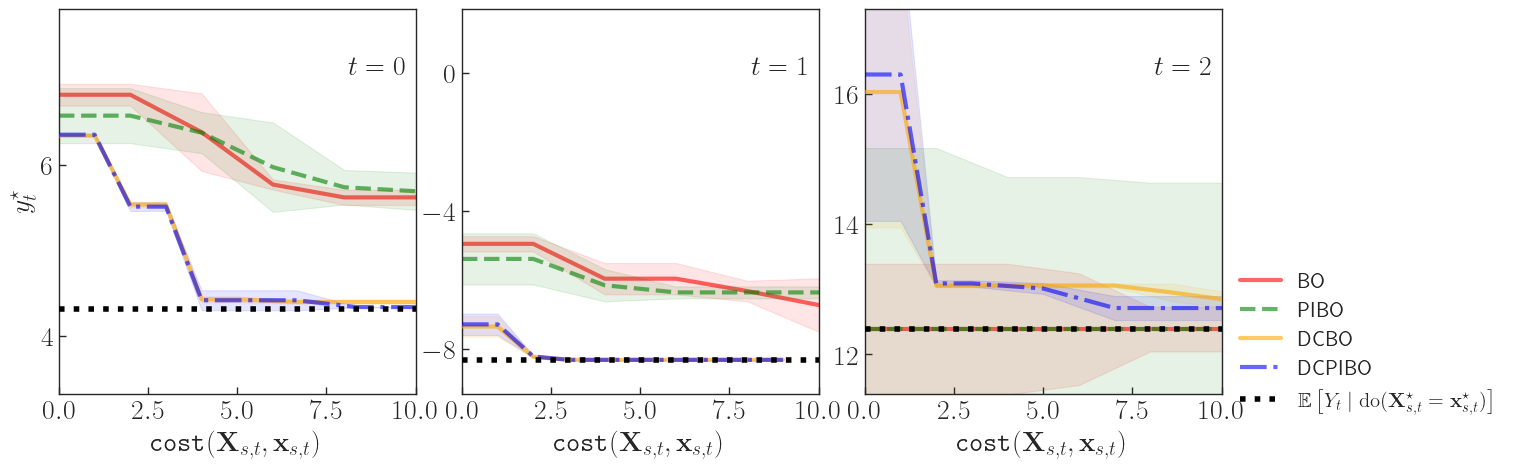

In [95]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    good_exp_per_trial_cost,
    good_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

### Bad prior

In [56]:
bad_data = get_relevant_results(results=bad_results,replicates=R)
bad_exp_optimal_outcome_values_during_trials, bad_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=bad_data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

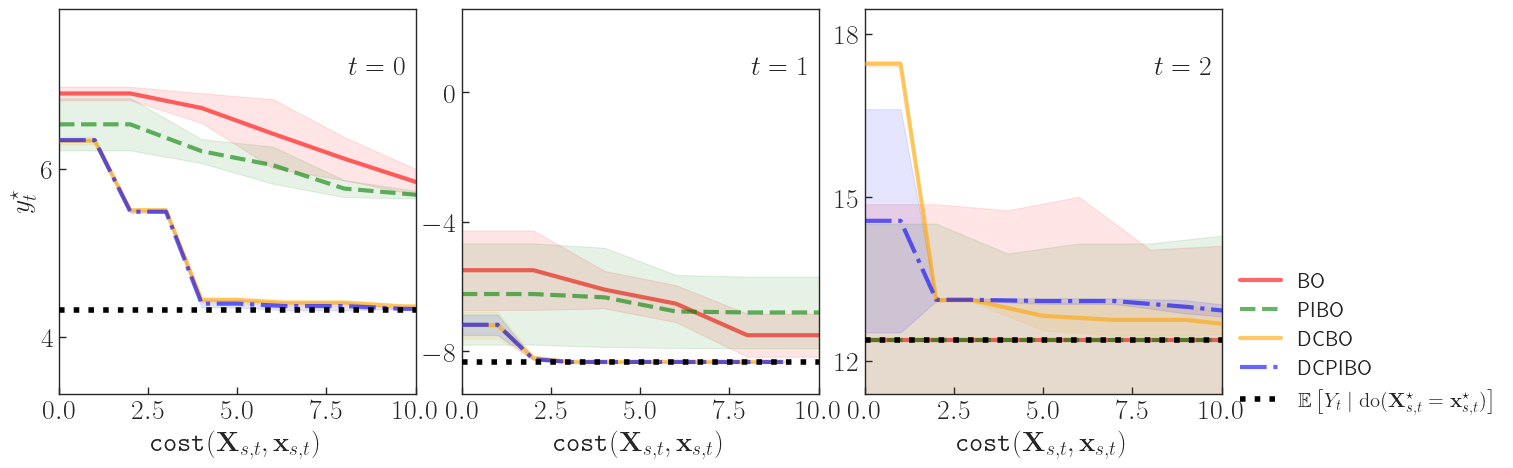

In [57]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    bad_exp_per_trial_cost,
    bad_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

### Very bad prior

In [58]:
# very_bad_data = get_relevant_results(results=very_bad_results,replicates=R)
# very_bad_exp_optimal_outcome_values_during_trials, very_bad_exp_per_trial_cost = elaborate(number_of_interventions=None, 
#                                                                          n_replicates=R, 
#                                                                          data=very_bad_data, 
#                                                                          best_objective_values=true_objective_values, 
#                                                                          T=T)

In [59]:
# # Each frame corresponds to one time-slice.
# plot_expected_opt_curve_paper(T,
#     true_objective_values,
#     very_bad_exp_per_trial_cost,
#     very_bad_exp_optimal_outcome_values_during_trials,
#     plot_params,  
#     fig_size = (15,5))

## Gap Metric

In [60]:
def compute_gap_values(T, summary):
    G_BO=0
    G_PIBO=0
    G_DCBO=0
    G_DCPIBO=0
    list_gaps=[]
    summary_list = list(summary.values())
    for i in range(len(summary_list)):
        for t in range(T):
            # print(summary_list[i][t][0])
            if i==0:
                G_BO=G_BO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_BO/T)
            elif i==1:
                G_PIBO=G_PIBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_PIBO/T)
            elif i==2:
                G_DCBO=G_DCBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_DCBO/T)
            elif i==3:
                G_DCPIBO=G_DCPIBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_DCPIBO/T)
    return list_gaps

### Good Gap Metric

In [96]:
good_t_i_l = get_common_initial_values(T=T,
                                  data=good_data,
                                  n_replicates=R)

good_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                           exp_optimal_outcome_values_during_trials=good_exp_optimal_outcome_values_during_trials,
                           n_trials=N,
                           T=T,
                           n_decimal=1)

good_summary = gap_metric_standard(T=T,
                             data=good_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = good_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=good_w_c_d)

good_list = compute_gap_values(T, good_summary)

In [97]:
good_summary

{'BO': [[0.2784139267892487, 0.006292429397103695],
  [0.38452244340786973, 0.11764449796049387],
  [1.0526315789473684, 0.0]],
 'PIBO': [[0.24533695358342147, 0.04907071406539797],
  [0.36984710672562393, 0.08808331403789671],
  [1.0526315789473684, 0.0]],
 'DCBO': [[0.5767688420800674, 0.0015775331431803943],
  [0.8947368421052632, 0.0],
  [0.49984029154113424, 0.011545859919563896]],
 'DCPIBO': [[0.6796780843934996, 0.000981472006968516],
  [0.8947368421052632, 0.0],
  [0.501364814267402, 0.01353049962043857]]}

In [98]:
good_list

[0.5718559830481623, 0.5559385464188046, 0.657115325242155, 0.6919265802553882]

### Bad Gap Metric

In [64]:
bad_t_i_l = get_common_initial_values(T=T,
                                  data=bad_data,
                                  n_replicates=R)

bad_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                          exp_optimal_outcome_values_during_trials=bad_exp_optimal_outcome_values_during_trials,
                          n_trials=N,
                          T=T,
                          n_decimal=1)

bad_summary = gap_metric_standard(T=T,
                             data=bad_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = bad_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=bad_w_c_d)

bad_list = compute_gap_values(T, bad_summary)

In [65]:
bad_summary

{'BO': [[0.2561331918902802, 0.032653908797716416],
  [0.31990794872597356, 0.22936693084173354],
  [1.0526315789473684, 0.0]],
 'PIBO': [[0.26679512230838603, 0.0162681903088551],
  [0.46733911605642015, 0.04668358531110359],
  [1.0526315789473684, 0.0]],
 'DCBO': [[0.5174658453902022, 0.005377737974316815],
  [0.8947368421052632, 0.0],
  [0.507553740995299, 0.00490400242553109]],
 'DCPIBO': [[0.6284762417249597, 0.00035299683592420356],
  [0.8947368421052632, 0.0],
  [0.5064518425981661, 0.018654189042828836]]}

In [66]:
bad_list

[0.5428909065212074,
 0.5955886057707248,
 0.6399188094969215,
 0.6765549754761296]